In [4]:
import numpy as np
import pandas as pd
import os
import json
import re
import matplotlib.pyplot as plt
import glob

In [23]:
folder_path = "/Users/jongchan/Dropbox/EmbodiedAI/ICCM2025/processed"
folders = glob.glob(os.path.join(folder_path, "*"))
user_summary = {}
index = 1
for f in folders:
    directory, folder_name = os.path.split(f)
    filtered_action_logs = glob.glob(os.path.join(f, "*filtered_action_logs.json"))[0]
    with open(filtered_action_logs, "r") as file:
        filtered_action_logs_data = json.load(file)
    
    test_output = glob.glob(os.path.join(f, "*test_output.json"))[0]
    with open(test_output, "r") as file:
        test_output_data = json.load(file)

    ## Calculate the activaion values
    my_dict = calc_activation(test_output_data, decay_rate=0.3)
    y_values = np.array([v[0]['search_time'] for v in filtered_action_logs_data.values()]) # Search Time
    y_total = np.sum(y_values)
    proportion_y = (y_values / y_total)*100
    x_values = list(my_dict.keys())
    user_summary[folder_name] = proportion_y

In [51]:
ST_summary = {}
lst_mean = []
lst_std = []
lst_mean_std1 = []
lst_mean_std2 = []
for i in range(len(x_values[:-1])):
    mean = np.mean([v[i] for k, v in user_summary.items()])
    stdev = np.std([v[i] for k, v in user_summary.items()])
    lst_mean.append(mean)
    lst_std.append(stdev)
    lst_mean_std1.append(mean-stdev)
    lst_mean_std2.append(mean+stdev)

ST_summary['mean'] = lst_mean
ST_summary['std'] = lst_std
ST_summary['mean-std'] = lst_mean_std1
ST_summary['mean+std'] = lst_mean_std2

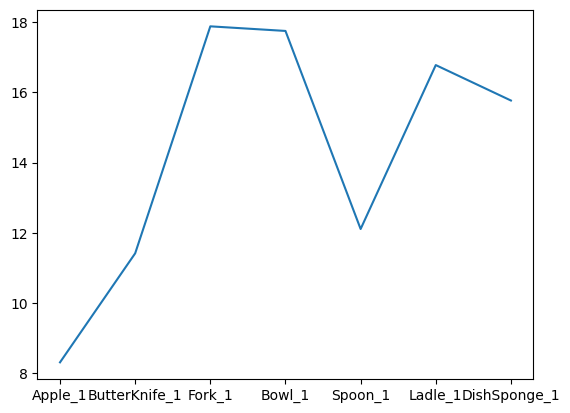

In [129]:
plt.figure()
plt.plot(x_values[:-1], ST_summary['mean'])
# plt.plot(x_values[:-1], ST_summary['std'])
# plt.plot(x_values[:-1], ST_summary['mean-std'])
# plt.plot(x_values[:-1], ST_summary['mean+std'])

---
# Equation 1.

In [109]:
def calc_activation(test_output_data, decay_rate=0.3):
    my_dict = {}
    for k, v in test_output_data.items():
        my_dict[k] = {}
        ## Original
        B_i = 0
        ## 9 different combinations
        B_i_H_interactables_S_interactables = 0
        B_i_H_interactables_S_pickupables = 0
        B_i_H_interactables_S_openables = 0
        B_i_H_pickupables_S_interactables = 0
        B_i_H_pickupables_S_pickupables = 0
        B_i_H_pickupables_S_openables = 0
        B_i_H_openables_S_interactables = 0
        B_i_H_openables_S_pickupables = 0
        B_i_H_openables_S_openables = 0
        
        for obs in v['Observations']:
            duration = obs['End Time'] - obs['Start Time']
            elapsed_time_s = obs['Current Time'] - obs['Start Time']
            elapsed_time_e = obs['Current Time'] - obs['End Time']
            interactables = obs['Num Unique Interactable Objects']
            pickupables = obs['Num Unique Pickupable Objects']
            openables = obs['Num Unique Openable Objects']

            H_interactables = np.log2(interactables) 
            H_pickupables = np.log2(pickupables)
            H_openables = np.log2(openables)
            S_interactables = duration / interactables
            S_pickupables = duration / pickupables
            S_openables = duration / openables
            
            ## 1. Calculate actiation using the original equation
            B_i += elapsed_time_e ** (-decay_rate) # Original equation
            
            ## 2. Calculate actiation using 9 different combinations
            B_i_H_interactables_S_interactables += (elapsed_time_e ** (-decay_rate * H_interactables)) ** S_interactables
            B_i_H_interactables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_interactables)) ** S_pickupables
            B_i_H_interactables_S_openables += (elapsed_time_e ** (-decay_rate * H_interactables)) ** S_openables

            B_i_H_pickupables_S_interactables += (elapsed_time_e ** (-decay_rate * H_pickupables)) ** S_interactables
            B_i_H_pickupables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_pickupables)) ** S_pickupables
            B_i_H_pickupables_S_openables += (elapsed_time_e ** (-decay_rate * H_pickupables)) ** S_openables

            B_i_H_openables_S_interactables += (elapsed_time_e ** (-decay_rate * H_openables)) ** S_interactables
            B_i_H_openables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_openables)) ** S_pickupables
            B_i_H_openables_S_openables += (elapsed_time_e ** (-decay_rate * H_openables)) ** S_openables
        
        ## 
        B_i = np.log(B_i)
        B_i_H_interactables_S_interactables = np.log(B_i_H_interactables_S_interactables)
        B_i_H_interactables_S_pickupables = np.log(B_i_H_interactables_S_pickupables)
        B_i_H_interactables_S_openables = np.log(B_i_H_interactables_S_openables)
        B_i_H_pickupables_S_interactables = np.log(max(B_i_H_pickupables_S_interactables, 1e-6))
        B_i_H_pickupables_S_pickupables = np.log(max(B_i_H_pickupables_S_pickupables, 1e-6))
        B_i_H_pickupables_S_openables = np.log(max(B_i_H_pickupables_S_openables, 1e-6))
        B_i_H_openables_S_interactables = np.log(max(B_i_H_openables_S_interactables, 1e-6))
        B_i_H_openables_S_pickupables = np.log(max(B_i_H_openables_S_pickupables, 1e-6))
        B_i_H_openables_S_openables = np.log(max(B_i_H_openables_S_openables, 1e-6))
        
        
        ## Store results
        my_dict[k] = {
            'B_i': B_i,
            'B_i_H_interactables_S_interactables': B_i_H_interactables_S_interactables,
            'B_i_H_interactables_S_pickupables': B_i_H_interactables_S_pickupables,
            'B_i_H_interactables_S_openables': B_i_H_interactables_S_openables,
            'B_i_H_pickupables_S_interactables': B_i_H_pickupables_S_interactables,
            'B_i_H_pickupables_S_pickupables': B_i_H_pickupables_S_pickupables,
            'B_i_H_pickupables_S_openables': B_i_H_pickupables_S_openables,
            'B_i_H_openables_S_interactables': B_i_H_openables_S_interactables,
            'B_i_H_openables_S_pickupables': B_i_H_openables_S_pickupables,
            'B_i_H_openables_S_openables': B_i_H_openables_S_openables,
        }
    return my_dict


In [112]:
folder_path = "/Users/jongchan/Dropbox/EmbodiedAI/ICCM2025/processed"
folders = glob.glob(os.path.join(folder_path, "*"))
user_summary_eqn1 = {}
index = 1
for f in folders:
    directory, folder_name = os.path.split(f)
    filtered_action_logs = glob.glob(os.path.join(f, "*filtered_action_logs.json"))[0]
    with open(filtered_action_logs, "r") as file:
        filtered_action_logs_data = json.load(file)
    
    test_output = glob.glob(os.path.join(f, "*test_output.json"))[0]
    with open(test_output, "r") as file:
        test_output_data = json.load(file)

    ## Calculate the activaion values
    my_dict = calc_activation(test_output_data, decay_rate=0.3)
    user_summary_eqn1[folder_name] = my_dict
    y_values = np.array([v[0]['search_time'] for v in filtered_action_logs_data.values()]) # Search Time
    x_values = list(my_dict.keys())

    # Extract all activation values manually
    values_B_i = np.array([v['B_i'] for v in my_dict.values()])
    values_B_i_H_interactables_S_interactables = np.array([v['B_i_H_interactables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_pickupables = np.array([v['B_i_H_interactables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_openables = np.array([v['B_i_H_interactables_S_openables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_interactables = np.array([v['B_i_H_pickupables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_pickupables = np.array([v['B_i_H_pickupables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_openables = np.array([v['B_i_H_pickupables_S_openables'] for v in my_dict.values()])
    values_B_i_H_openables_S_interactables = np.array([v['B_i_H_openables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_openables_S_pickupables = np.array([v['B_i_H_openables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_openables_S_openables = np.array([v['B_i_H_openables_S_openables'] for v in my_dict.values()])

    # ## Create subplots (Search Time + 12 activation metrics)
    # fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4 rows, 3 columns

    # ## Search time plot (first one)
    # axes[0, 0].plot(x_values[:-1], y_values, marker='o', linestyle='-', color='b')
    # axes[0, 0].set_title(f'{folder_name} - Search Time')
    # axes[0, 0].grid(True)

    # ## Activation metric plots
    # axes[0, 1].plot(x_values, values_B_i * -1, marker='o', linestyle='-', color='r')
    # axes[0, 1].set_title(f'B_i')
    # axes[0, 1].grid(True)

    # axes[0, 2].plot(x_values, values_B_i_H_interactables_S_interactables * -1, marker='o', linestyle='-', color='g')
    # axes[0, 2].set_title(f'B_i_H_interactables_S_interactables')
    # axes[0, 2].grid(True)

    # axes[1, 0].plot(x_values, values_B_i_H_interactables_S_pickupables * -1, marker='o', linestyle='-', color='b')
    # axes[1, 0].set_title(f'B_i_H_interactables_S_pickupables')
    # axes[1, 0].grid(True)

    # axes[1, 1].plot(x_values, values_B_i_H_interactables_S_openables * -1, marker='o', linestyle='-', color='m')
    # axes[1, 1].set_title(f'B_i_H_interactables_S_openables')
    # axes[1, 1].grid(True)

    # axes[1, 2].plot(x_values, values_B_i_H_pickupables_S_interactables * -1, marker='o', linestyle='-', color='c')
    # axes[1, 2].set_title(f'B_i_H_pickupables_S_interactables')
    # axes[1, 2].grid(True)

    # axes[2, 0].plot(x_values, values_B_i_H_pickupables_S_pickupables * -1, marker='o', linestyle='-', color='y')
    # axes[2, 0].set_title(f'B_i_H_pickupables_S_pickupables')
    # axes[2, 0].grid(True)

    # axes[2, 1].plot(x_values, values_B_i_H_pickupables_S_openables * -1, marker='o', linestyle='-', color='k')
    # axes[2, 1].set_title(f'B_i_H_pickupables_S_openables')
    # axes[2, 1].grid(True)

    # axes[2, 2].plot(x_values, values_B_i_H_openables_S_interactables * -1, marker='o', linestyle='-', color='r')
    # axes[2, 2].set_title(f'B_i_H_openables_S_interactables')
    # axes[2, 2].grid(True)

    # axes[3, 0].plot(x_values, values_B_i_H_openables_S_pickupables * -1, marker='o', linestyle='-', color='g')
    # axes[3, 0].set_title(f'B_i_H_openables_S_pickupables')
    # axes[3, 0].grid(True)

    # axes[3, 1].plot(x_values, values_B_i_H_openables_S_openables * -1, marker='o', linestyle='-', color='b')
    # axes[3, 1].set_title(f'B_i_H_openables_S_openables')
    # axes[3, 1].grid(True)

    # ## Rotate x-axis labels
    # for ax in axes.flatten():
    #     ax.tick_params(axis='x', rotation=90)

    # plt.tight_layout()
    # plt.show()
    # print("\n", "="*120, "\n")
    
    index +=1 

In [152]:
by_person_eqn1 = {}
for key in my_dict['Apple_1'].keys():
    by_person_eqn1[key] = {}
    for obj in x_values[:-1]:
        lst = []
        for user, summary in user_summary_eqn1.items():
            lst.append(summary[obj][key])
        by_person_eqn1[key][obj] = np.mean(lst)

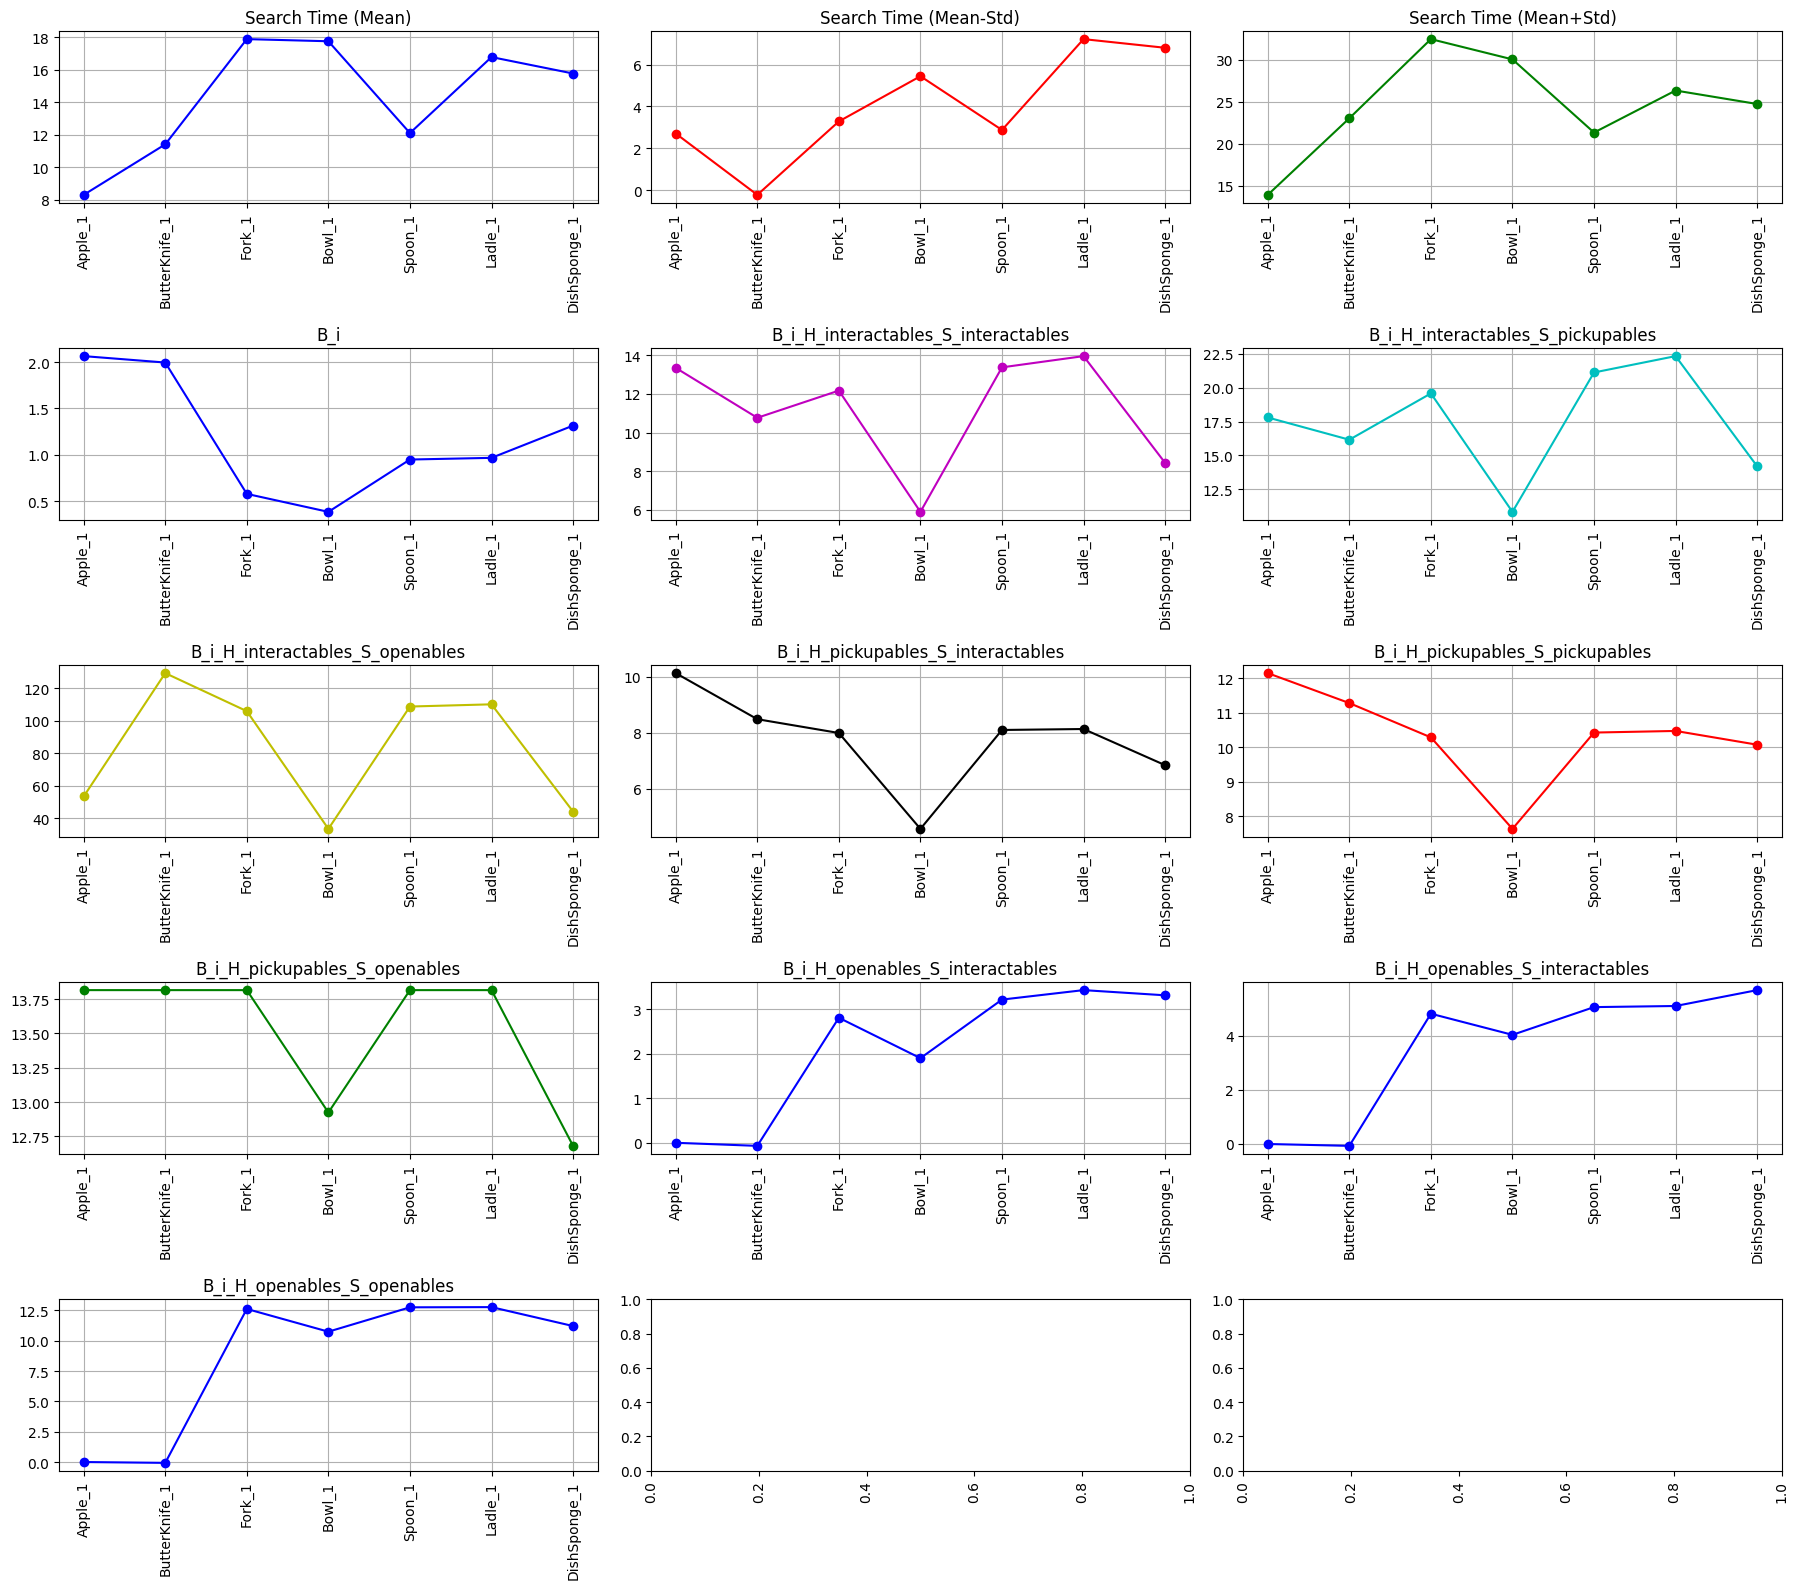

In [147]:
# ST_summary['mean'] = lst_mean
# ST_summary['std'] = lst_std
# ST_summary['mean-std'] = lst_mean_std1
# ST_summary['mean+std'] = lst_mean_std2

## Create subplots (Search Time + 12 activation metrics)
fig, axes = plt.subplots(5, 3, figsize=(18, 16))  # 4 rows, 3 columns

## Search time plot (first one)
axes[0, 0].plot(x_values[:-1], ST_summary['mean'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title(f'Search Time (Mean)')
axes[0, 0].grid(True)

## Activation metric plots
axes[0, 1].plot(x_values[:-1], ST_summary['mean-std'], marker='o', linestyle='-', color='r')
axes[0, 1].set_title(f'Search Time (Mean-Std)')
axes[0, 1].grid(True)

axes[0, 2].plot(x_values[:-1], ST_summary['mean+std'], marker='o', linestyle='-', color='g')
axes[0, 2].set_title(f'Search Time (Mean+Std)')
axes[0, 2].grid(True)

axes[1, 0].plot(x_values[:-1],[v*-1 for v in by_person_eqn1['B_i'].values()], marker='o', linestyle='-', color='b')
axes[1, 0].set_title(f'B_i')
axes[1, 0].grid(True)

axes[1, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_interactables_S_interactables'].values()], marker='o', linestyle='-', color='m')
axes[1, 1].set_title(f'B_i_H_interactables_S_interactables')
axes[1, 1].grid(True)

axes[1, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_interactables_S_pickupables'].values()], marker='o', linestyle='-', color='c')
axes[1, 2].set_title(f'B_i_H_interactables_S_pickupables')
axes[1, 2].grid(True)

axes[2, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_interactables_S_openables'].values()], marker='o', linestyle='-', color='y')
axes[2, 0].set_title(f'B_i_H_interactables_S_openables')
axes[2, 0].grid(True)

axes[2, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_pickupables_S_interactables'].values()], marker='o', linestyle='-', color='k')
axes[2, 1].set_title(f'B_i_H_pickupables_S_interactables')
axes[2, 1].grid(True)

axes[2, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_pickupables_S_pickupables'].values()], marker='o', linestyle='-', color='r')
axes[2, 2].set_title(f'B_i_H_pickupables_S_pickupables')
axes[2, 2].grid(True)

axes[3, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_pickupables_S_openables'].values()], marker='o', linestyle='-', color='g')
axes[3, 0].set_title(f'B_i_H_pickupables_S_openables')
axes[3, 0].grid(True)

axes[3, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_openables_S_interactables'].values()], marker='o', linestyle='-', color='b')
axes[3, 1].set_title(f'B_i_H_openables_S_interactables')
axes[3, 1].grid(True)

axes[3, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_openables_S_pickupables'].values()], marker='o', linestyle='-', color='b')
axes[3, 2].set_title(f'B_i_H_openables_S_interactables')
axes[3, 2].grid(True)

axes[4, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn1['B_i_H_openables_S_openables'].values()], marker='o', linestyle='-', color='b')
axes[4, 0].set_title(f'B_i_H_openables_S_openables')
axes[4, 0].grid(True)

## Rotate x-axis labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

    

# 
---
# Equation 2

In [6]:
def calc_activation_2(test_output_data, decay_rate=0.3):
    my_dict = {}
    for k, v in test_output_data.items():
        my_dict[k] = {}
        ## Original
        B_i = 0
        ## 9 different combinations
        B_i_H_interactables_S_interactables = 0
        B_i_H_interactables_S_pickupables = 0
        B_i_H_interactables_S_openables = 0
        B_i_H_pickupables_S_interactables = 0
        B_i_H_pickupables_S_pickupables = 0
        B_i_H_pickupables_S_openables = 0
        B_i_H_openables_S_interactables = 0
        B_i_H_openables_S_pickupables = 0
        B_i_H_openables_S_openables = 0
        
        for obs in v['Observations']:
            duration = obs['End Time'] - obs['Start Time']
            elapsed_time_s = obs['Current Time'] - obs['Start Time']
            elapsed_time_e = obs['Current Time'] - obs['End Time']
            interactables = obs['Num Unique Interactable Objects']
            pickupables = obs['Num Unique Pickupable Objects']
            openables = obs['Num Unique Openable Objects']

            H_interactables = np.log2(interactables) 
            H_pickupables = np.log2(pickupables)
            H_openables = np.log2(openables)
            S_interactables = duration / interactables
            S_pickupables = duration / pickupables
            S_openables = duration / openables
            
            ## 1. Calculate actiation using the original equation
            B_i += elapsed_time_e ** (-decay_rate) # Original equation
            
            ## 2. Calculate actiation using 9 different combinations
            B_i_H_interactables_S_interactables += (elapsed_time_e ** (-decay_rate * H_interactables)) * S_interactables
            B_i_H_interactables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_interactables)) * S_pickupables
            B_i_H_interactables_S_openables += (elapsed_time_e ** (-decay_rate * H_interactables)) * S_openables

            B_i_H_pickupables_S_interactables += (elapsed_time_e ** (-decay_rate * H_pickupables)) * S_interactables
            B_i_H_pickupables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_pickupables)) * S_pickupables
            B_i_H_pickupables_S_openables += (elapsed_time_e ** (-decay_rate * H_pickupables)) * S_openables

            B_i_H_openables_S_interactables += (elapsed_time_e ** (-decay_rate * H_openables)) * S_interactables
            B_i_H_openables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_openables)) * S_pickupables
            B_i_H_openables_S_openables += (elapsed_time_e ** (-decay_rate * H_openables)) * S_openables

        ## 
        B_i = np.log(B_i)
        B_i_H_interactables_S_interactables = np.log(B_i_H_interactables_S_interactables)
        B_i_H_interactables_S_pickupables = np.log(B_i_H_interactables_S_pickupables)
        B_i_H_interactables_S_openables = np.log(B_i_H_interactables_S_openables)
        B_i_H_pickupables_S_interactables = np.log(max(B_i_H_pickupables_S_interactables, 1e-6))
        B_i_H_pickupables_S_pickupables = np.log(max(B_i_H_pickupables_S_pickupables, 1e-6))
        B_i_H_pickupables_S_openables = np.log(max(B_i_H_pickupables_S_openables, 1e-6))
        B_i_H_openables_S_interactables = np.log(max(B_i_H_openables_S_interactables, 1e-6))
        B_i_H_openables_S_pickupables = np.log(max(B_i_H_openables_S_pickupables, 1e-6))
        B_i_H_openables_S_openables = np.log(max(B_i_H_openables_S_openables, 1e-6))
        
        
        ## Store results
        my_dict[k] = {
            'B_i': B_i,
            'B_i_H_interactables_S_interactables': B_i_H_interactables_S_interactables,
            'B_i_H_interactables_S_pickupables': B_i_H_interactables_S_pickupables,
            'B_i_H_interactables_S_openables': B_i_H_interactables_S_openables,
            'B_i_H_pickupables_S_interactables': B_i_H_pickupables_S_interactables,
            'B_i_H_pickupables_S_pickupables': B_i_H_pickupables_S_pickupables,
            'B_i_H_pickupables_S_openables': B_i_H_pickupables_S_openables,
            'B_i_H_openables_S_interactables': B_i_H_openables_S_interactables,
            'B_i_H_openables_S_pickupables': B_i_H_openables_S_pickupables,
            'B_i_H_openables_S_openables': B_i_H_openables_S_openables,
        }
    return my_dict

In [114]:
folder_path = "/Users/jongchan/Dropbox/EmbodiedAI/ICCM2025/processed"
folders = glob.glob(os.path.join(folder_path, "*"))
user_summary_eqn2 = {}
index = 1
for f in folders:
    directory, folder_name = os.path.split(f)
    filtered_action_logs = glob.glob(os.path.join(f, "*filtered_action_logs.json"))[0]
    with open(filtered_action_logs, "r") as file:
        filtered_action_logs_data = json.load(file)
    
    test_output = glob.glob(os.path.join(f, "*test_output.json"))[0]
    with open(test_output, "r") as file:
        test_output_data = json.load(file)

    ## Calculate the activaion values
    my_dict = calc_activation_2(test_output_data, decay_rate=0.3)
    user_summary_eqn2[folder_name] = my_dict
    y_values = np.array([v[0]['search_time'] for v in filtered_action_logs_data.values()]) # Search Time
    x_values = list(my_dict.keys())

    # Extract all activation values manually
    values_B_i = np.array([v['B_i'] for v in my_dict.values()])
    values_B_i_H_interactables_S_interactables = np.array([v['B_i_H_interactables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_pickupables = np.array([v['B_i_H_interactables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_openables = np.array([v['B_i_H_interactables_S_openables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_interactables = np.array([v['B_i_H_pickupables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_pickupables = np.array([v['B_i_H_pickupables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_openables = np.array([v['B_i_H_pickupables_S_openables'] for v in my_dict.values()])
    values_B_i_H_openables_S_interactables = np.array([v['B_i_H_openables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_openables_S_pickupables = np.array([v['B_i_H_openables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_openables_S_openables = np.array([v['B_i_H_openables_S_openables'] for v in my_dict.values()])

    # ## Create subplots (Search Time + 12 activation metrics)
    # fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4 rows, 3 columns

    # ## Search time plot (first one)
    # axes[0, 0].plot(x_values[:-1], y_values, marker='o', linestyle='-', color='b')
    # axes[0, 0].set_title(f'{folder_name} - Search Time')
    # axes[0, 0].grid(True)

    # ## Activation metric plots
    # axes[0, 1].plot(x_values, values_B_i * -1, marker='o', linestyle='-', color='r')
    # axes[0, 1].set_title(f'B_i')
    # axes[0, 1].grid(True)

    # axes[0, 2].plot(x_values, values_B_i_H_interactables_S_interactables * -1, marker='o', linestyle='-', color='g')
    # axes[0, 2].set_title(f'B_i_H_interactables_S_interactables')
    # axes[0, 2].grid(True)

    # axes[1, 0].plot(x_values, values_B_i_H_interactables_S_pickupables * -1, marker='o', linestyle='-', color='b')
    # axes[1, 0].set_title(f'B_i_H_interactables_S_pickupables')
    # axes[1, 0].grid(True)

    # axes[1, 1].plot(x_values, values_B_i_H_interactables_S_openables * -1, marker='o', linestyle='-', color='m')
    # axes[1, 1].set_title(f'B_i_H_interactables_S_openables')
    # axes[1, 1].grid(True)

    # axes[1, 2].plot(x_values, values_B_i_H_pickupables_S_interactables * -1, marker='o', linestyle='-', color='c')
    # axes[1, 2].set_title(f'B_i_H_pickupables_S_interactables')
    # axes[1, 2].grid(True)

    # axes[2, 0].plot(x_values, values_B_i_H_pickupables_S_pickupables * -1, marker='o', linestyle='-', color='y')
    # axes[2, 0].set_title(f'B_i_H_pickupables_S_pickupables')
    # axes[2, 0].grid(True)

    # axes[2, 1].plot(x_values, values_B_i_H_pickupables_S_openables * -1, marker='o', linestyle='-', color='k')
    # axes[2, 1].set_title(f'B_i_H_pickupables_S_openables')
    # axes[2, 1].grid(True)

    # axes[2, 2].plot(x_values, values_B_i_H_openables_S_interactables * -1, marker='o', linestyle='-', color='r')
    # axes[2, 2].set_title(f'B_i_H_openables_S_interactables')
    # axes[2, 2].grid(True)

    # axes[3, 0].plot(x_values, values_B_i_H_openables_S_pickupables * -1, marker='o', linestyle='-', color='g')
    # axes[3, 0].set_title(f'B_i_H_openables_S_pickupables')
    # axes[3, 0].grid(True)

    # axes[3, 1].plot(x_values, values_B_i_H_openables_S_openables * -1, marker='o', linestyle='-', color='b')
    # axes[3, 1].set_title(f'B_i_H_openables_S_openables')
    # axes[3, 1].grid(True)

    # ## Rotate x-axis labels
    # for ax in axes.flatten():
    #     ax.tick_params(axis='x', rotation=90)

    # plt.tight_layout()
    # plt.show()

    # print("\n", "="*120, "\n")
    index +=1 

In [151]:
by_person_eqn2 = {}
for key in my_dict['Apple_1'].keys():
    by_person_eqn2[key] = {}
    for obj in x_values[:-1]:
        lst = []
        for user, summary in user_summary_eqn2.items():
            lst.append(summary[obj][key])
        by_person_eqn2[key][obj] = np.mean(lst)

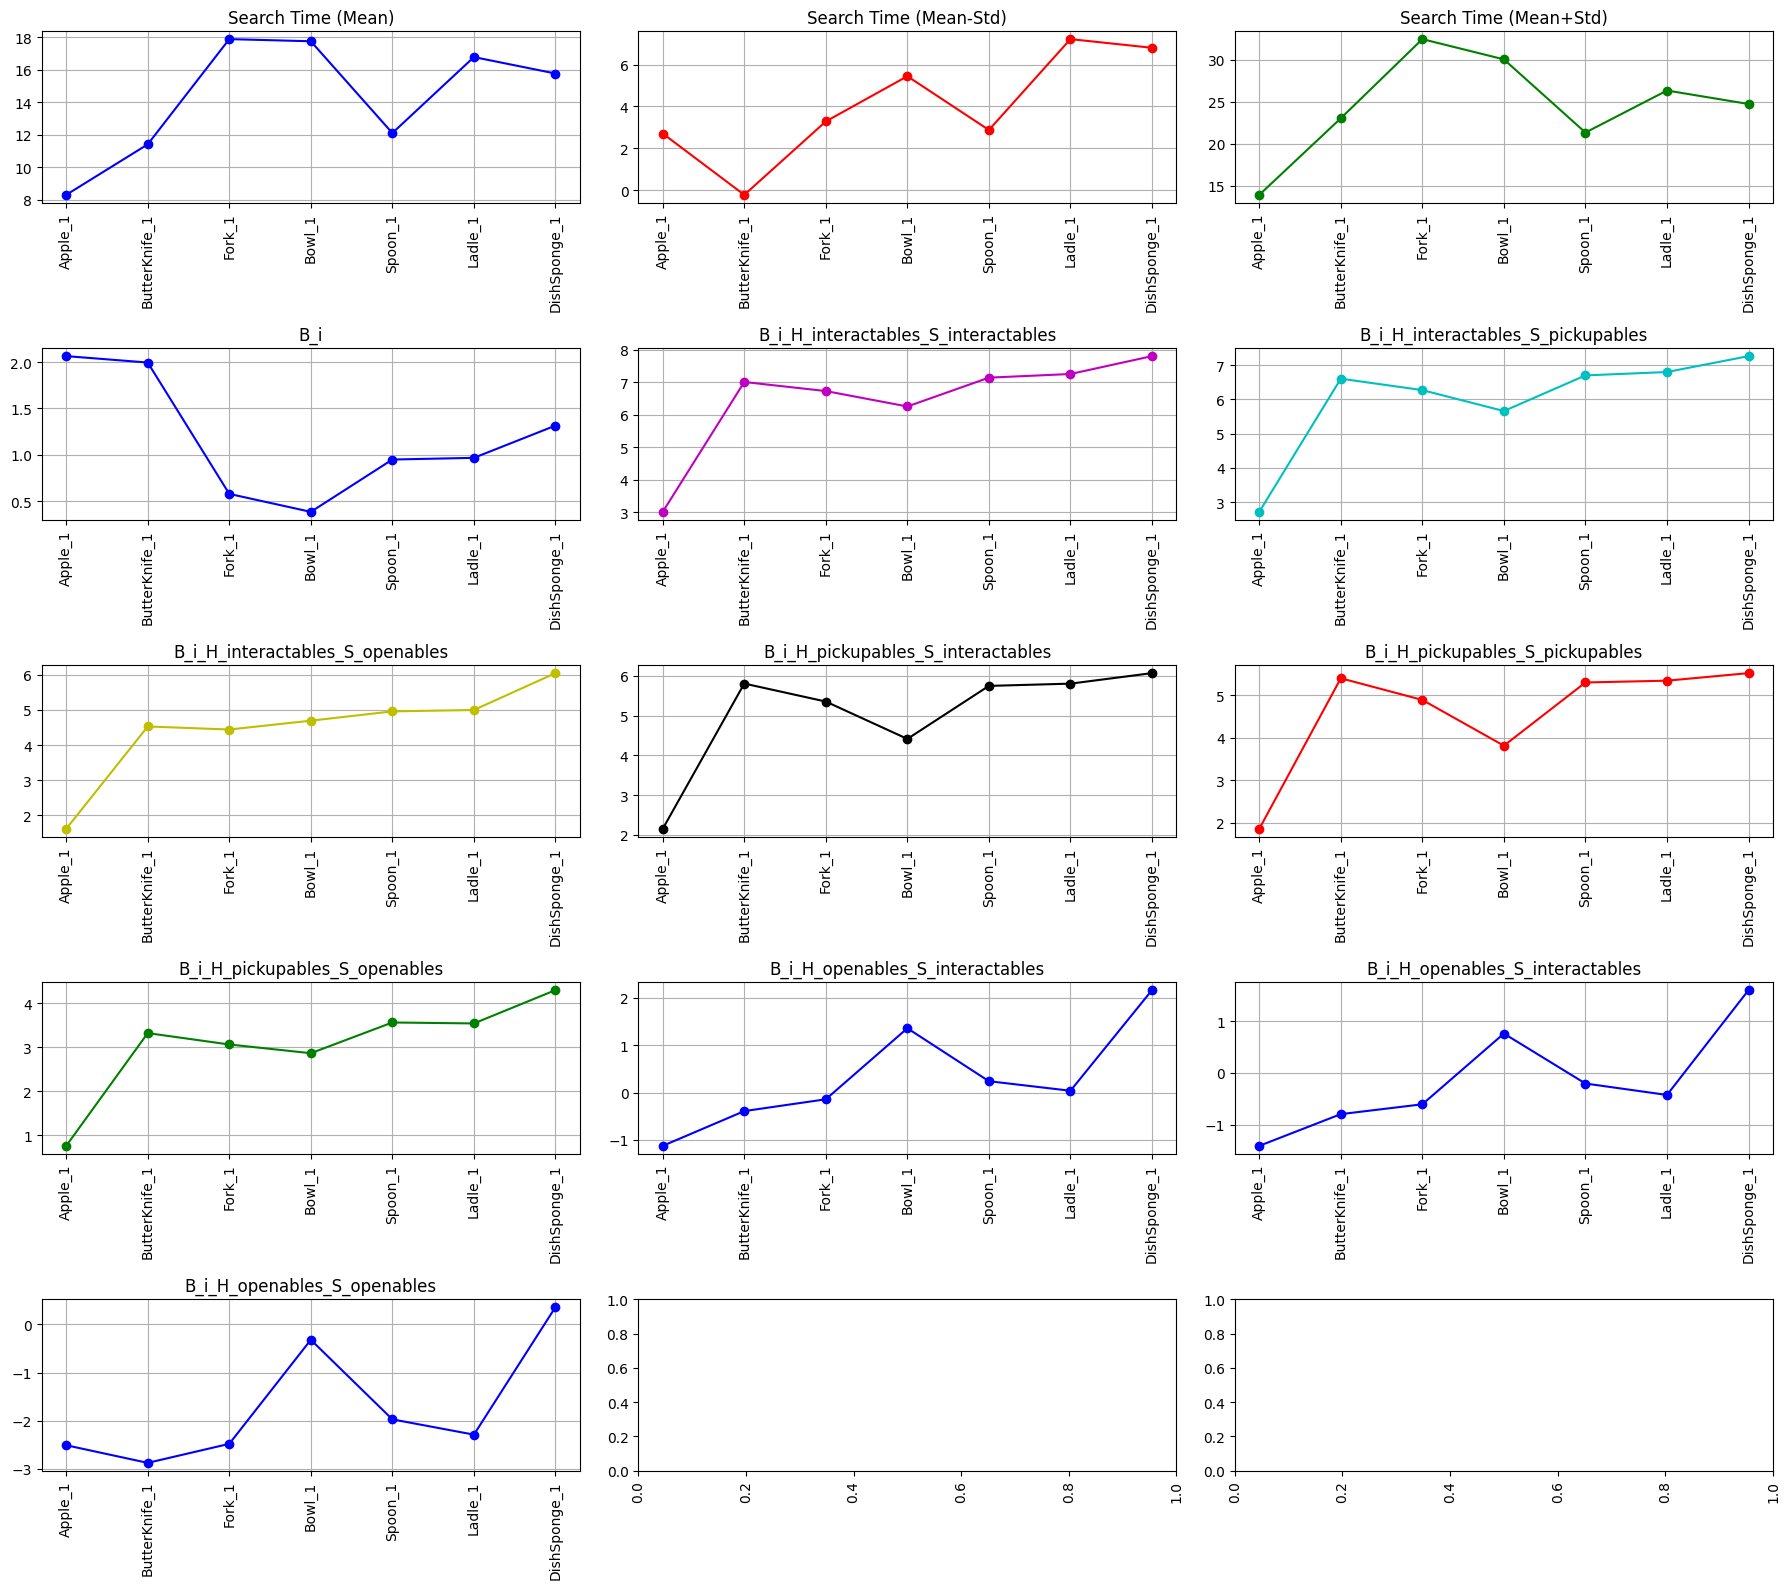

In [148]:

## Create subplots (Search Time + 12 activation metrics)
fig, axes = plt.subplots(5, 3, figsize=(18, 16))  # 4 rows, 3 columns

## Search time plot (first one)
axes[0, 0].plot(x_values[:-1], ST_summary['mean'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title(f'Search Time (Mean)')
axes[0, 0].grid(True)

## Activation metric plots
axes[0, 1].plot(x_values[:-1], ST_summary['mean-std'], marker='o', linestyle='-', color='r')
axes[0, 1].set_title(f'Search Time (Mean-Std)')
axes[0, 1].grid(True)

axes[0, 2].plot(x_values[:-1], ST_summary['mean+std'], marker='o', linestyle='-', color='g')
axes[0, 2].set_title(f'Search Time (Mean+Std)')
axes[0, 2].grid(True)

axes[1, 0].plot(x_values[:-1],[v*-1 for v in by_person_eqn2['B_i'].values()], marker='o', linestyle='-', color='b')
axes[1, 0].set_title(f'B_i')
axes[1, 0].grid(True)

axes[1, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_interactables_S_interactables'].values()], marker='o', linestyle='-', color='m')
axes[1, 1].set_title(f'B_i_H_interactables_S_interactables')
axes[1, 1].grid(True)

axes[1, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_interactables_S_pickupables'].values()], marker='o', linestyle='-', color='c')
axes[1, 2].set_title(f'B_i_H_interactables_S_pickupables')
axes[1, 2].grid(True)

axes[2, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_interactables_S_openables'].values()], marker='o', linestyle='-', color='y')
axes[2, 0].set_title(f'B_i_H_interactables_S_openables')
axes[2, 0].grid(True)

axes[2, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_pickupables_S_interactables'].values()], marker='o', linestyle='-', color='k')
axes[2, 1].set_title(f'B_i_H_pickupables_S_interactables')
axes[2, 1].grid(True)

axes[2, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_pickupables_S_pickupables'].values()], marker='o', linestyle='-', color='r')
axes[2, 2].set_title(f'B_i_H_pickupables_S_pickupables')
axes[2, 2].grid(True)

axes[3, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_pickupables_S_openables'].values()], marker='o', linestyle='-', color='g')
axes[3, 0].set_title(f'B_i_H_pickupables_S_openables')
axes[3, 0].grid(True)

axes[3, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_openables_S_interactables'].values()], marker='o', linestyle='-', color='b')
axes[3, 1].set_title(f'B_i_H_openables_S_interactables')
axes[3, 1].grid(True)

axes[3, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_openables_S_pickupables'].values()], marker='o', linestyle='-', color='b')
axes[3, 2].set_title(f'B_i_H_openables_S_interactables')
axes[3, 2].grid(True)

axes[4, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn2['B_i_H_openables_S_openables'].values()], marker='o', linestyle='-', color='b')
axes[4, 0].set_title(f'B_i_H_openables_S_openables')
axes[4, 0].grid(True)

## Rotate x-axis labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# 
---
# Equation 3

In [9]:
def calc_activation_3(test_output_data, decay_rate=0.3):
    my_dict = {}
    for k, v in test_output_data.items():
        my_dict[k] = {}
        ## Original
        B_i = 0
        ## 9 different combinations
        B_i_H_interactables_S_interactables = 0
        B_i_H_interactables_S_pickupables = 0
        B_i_H_interactables_S_openables = 0
        B_i_H_pickupables_S_interactables = 0
        B_i_H_pickupables_S_pickupables = 0
        B_i_H_pickupables_S_openables = 0
        B_i_H_openables_S_interactables = 0
        B_i_H_openables_S_pickupables = 0
        B_i_H_openables_S_openables = 0
        
        for obs in v['Observations']:
            duration = obs['End Time'] - obs['Start Time']
            elapsed_time_s = obs['Current Time'] - obs['Start Time']
            elapsed_time_e = obs['Current Time'] - obs['End Time']
            interactables = obs['Num Unique Interactable Objects']
            pickupables = obs['Num Unique Pickupable Objects']
            openables = obs['Num Unique Openable Objects']

            H_interactables = np.log2(interactables) 
            H_pickupables = np.log2(pickupables)
            H_openables = np.log2(openables)
            S_interactables = duration / interactables
            S_pickupables = duration / pickupables
            S_openables = duration / openables
            
            ## 1. Calculate actiation using the original equation
            B_i += elapsed_time_e ** (-decay_rate) # Original equation
            
            ## 2. Calculate actiation using 9 different combinations
            B_i_H_interactables_S_interactables += (elapsed_time_e * S_interactables) ** (-decay_rate * H_interactables)
            B_i_H_interactables_S_pickupables += (elapsed_time_e  * S_pickupables) ** (-decay_rate * H_interactables)
            B_i_H_interactables_S_openables += (elapsed_time_e  * S_openables) ** (-decay_rate * H_interactables)

            B_i_H_pickupables_S_interactables += (elapsed_time_e * S_interactables) ** (-decay_rate * H_pickupables)
            B_i_H_pickupables_S_pickupables += (elapsed_time_e  * S_pickupables)  ** (-decay_rate * H_pickupables)
            B_i_H_pickupables_S_openables += (elapsed_time_e  * S_openables)  ** (-decay_rate * H_pickupables)

            B_i_H_openables_S_interactables += (elapsed_time_e * S_interactables)  ** (-decay_rate * H_openables)
            B_i_H_openables_S_pickupables += (elapsed_time_e * S_pickupables)  ** (-decay_rate * H_openables)
            B_i_H_openables_S_openables += (elapsed_time_e * S_openables )** (-decay_rate * H_openables) 

        
        ## 
        B_i = np.log(B_i)
        B_i_H_interactables_S_interactables = np.log(B_i_H_interactables_S_interactables)
        B_i_H_interactables_S_pickupables = np.log(B_i_H_interactables_S_pickupables)
        B_i_H_interactables_S_openables = np.log(B_i_H_interactables_S_openables)
        B_i_H_pickupables_S_interactables = np.log(max(B_i_H_pickupables_S_interactables, 1e-6))
        B_i_H_pickupables_S_pickupables = np.log(max(B_i_H_pickupables_S_pickupables, 1e-6))
        B_i_H_pickupables_S_openables = np.log(max(B_i_H_pickupables_S_openables, 1e-6))
        B_i_H_openables_S_interactables = np.log(max(B_i_H_openables_S_interactables, 1e-6))
        B_i_H_openables_S_pickupables = np.log(max(B_i_H_openables_S_pickupables, 1e-6))
        B_i_H_openables_S_openables = np.log(max(B_i_H_openables_S_openables, 1e-6))
        
        
        ## Store results
        my_dict[k] = {
            'B_i': B_i,
            'B_i_H_interactables_S_interactables': B_i_H_interactables_S_interactables,
            'B_i_H_interactables_S_pickupables': B_i_H_interactables_S_pickupables,
            'B_i_H_interactables_S_openables': B_i_H_interactables_S_openables,
            'B_i_H_pickupables_S_interactables': B_i_H_pickupables_S_interactables,
            'B_i_H_pickupables_S_pickupables': B_i_H_pickupables_S_pickupables,
            'B_i_H_pickupables_S_openables': B_i_H_pickupables_S_openables,
            'B_i_H_openables_S_interactables': B_i_H_openables_S_interactables,
            'B_i_H_openables_S_pickupables': B_i_H_openables_S_pickupables,
            'B_i_H_openables_S_openables': B_i_H_openables_S_openables,
        }
    return my_dict

In [124]:
folder_path = "/Users/jongchan/Dropbox/EmbodiedAI/ICCM2025/processed"
folders = glob.glob(os.path.join(folder_path, "*"))
user_summary_eqn3 = {}
index = 1
for f in folders:
    directory, folder_name = os.path.split(f)
    filtered_action_logs = glob.glob(os.path.join(f, "*filtered_action_logs.json"))[0]
    with open(filtered_action_logs, "r") as file:
        filtered_action_logs_data = json.load(file)
    
    test_output = glob.glob(os.path.join(f, "*test_output.json"))[0]
    with open(test_output, "r") as file:
        test_output_data = json.load(file)

    ## Calculate the activaion values
    my_dict = calc_activation_3(test_output_data, decay_rate=0.3)
    user_summary_eqn3[folder_name] = my_dict
    y_values = np.array([v[0]['search_time'] for v in filtered_action_logs_data.values()]) # Search Time
    x_values = list(my_dict.keys())

    # Extract all activation values manually
    values_B_i = np.array([v['B_i'] for v in my_dict.values()])
    values_B_i_H_interactables_S_interactables = np.array([v['B_i_H_interactables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_pickupables = np.array([v['B_i_H_interactables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_openables = np.array([v['B_i_H_interactables_S_openables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_interactables = np.array([v['B_i_H_pickupables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_pickupables = np.array([v['B_i_H_pickupables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_openables = np.array([v['B_i_H_pickupables_S_openables'] for v in my_dict.values()])
    values_B_i_H_openables_S_interactables = np.array([v['B_i_H_openables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_openables_S_pickupables = np.array([v['B_i_H_openables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_openables_S_openables = np.array([v['B_i_H_openables_S_openables'] for v in my_dict.values()])

    # ## Create subplots (Search Time + 12 activation metrics)
    # fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4 rows, 3 columns

    # ## Search time plot (first one)
    # axes[0, 0].plot(x_values[:-1], y_values, marker='o', linestyle='-', color='b')
    # axes[0, 0].set_title(f'{folder_name} - Search Time')
    # axes[0, 0].grid(True)

    # ## Activation metric plots
    # axes[0, 1].plot(x_values, values_B_i * -1, marker='o', linestyle='-', color='r')
    # axes[0, 1].set_title(f'B_i')
    # axes[0, 1].grid(True)

    # axes[0, 2].plot(x_values, values_B_i_H_interactables_S_interactables * -1, marker='o', linestyle='-', color='g')
    # axes[0, 2].set_title(f'B_i_H_interactables_S_interactables')
    # axes[0, 2].grid(True)

    # axes[1, 0].plot(x_values, values_B_i_H_interactables_S_pickupables * -1, marker='o', linestyle='-', color='b')
    # axes[1, 0].set_title(f'B_i_H_interactables_S_pickupables')
    # axes[1, 0].grid(True)

    # axes[1, 1].plot(x_values, values_B_i_H_interactables_S_openables * -1, marker='o', linestyle='-', color='m')
    # axes[1, 1].set_title(f'B_i_H_interactables_S_openables')
    # axes[1, 1].grid(True)

    # axes[1, 2].plot(x_values, values_B_i_H_pickupables_S_interactables * -1, marker='o', linestyle='-', color='c')
    # axes[1, 2].set_title(f'B_i_H_pickupables_S_interactables')
    # axes[1, 2].grid(True)

    # axes[2, 0].plot(x_values, values_B_i_H_pickupables_S_pickupables * -1, marker='o', linestyle='-', color='y')
    # axes[2, 0].set_title(f'B_i_H_pickupables_S_pickupables')
    # axes[2, 0].grid(True)

    # axes[2, 1].plot(x_values, values_B_i_H_pickupables_S_openables * -1, marker='o', linestyle='-', color='k')
    # axes[2, 1].set_title(f'B_i_H_pickupables_S_openables')
    # axes[2, 1].grid(True)

    # axes[2, 2].plot(x_values, values_B_i_H_openables_S_interactables * -1, marker='o', linestyle='-', color='r')
    # axes[2, 2].set_title(f'B_i_H_openables_S_interactables')
    # axes[2, 2].grid(True)

    # axes[3, 0].plot(x_values, values_B_i_H_openables_S_pickupables * -1, marker='o', linestyle='-', color='g')
    # axes[3, 0].set_title(f'B_i_H_openables_S_pickupables')
    # axes[3, 0].grid(True)

    # axes[3, 1].plot(x_values, values_B_i_H_openables_S_openables * -1, marker='o', linestyle='-', color='b')
    # axes[3, 1].set_title(f'B_i_H_openables_S_openables')
    # axes[3, 1].grid(True)

    # ## Rotate x-axis labels
    # for ax in axes.flatten():
    #     ax.tick_params(axis='x', rotation=90)

    # plt.tight_layout()
    # plt.show()

    # print("\n", "="*120, "\n")
    index +=1 

In [153]:
#### by_person_eqn3 = {}
for key in my_dict['Apple_1'].keys():
    by_person_eqn3[key] = {}
    for obj in x_values[:-1]:
        lst = []
        for user, summary in user_summary_eqn3.items():
            lst.append(summary[obj][key])
        by_person_eqn3[key][obj] = np.mean(lst)

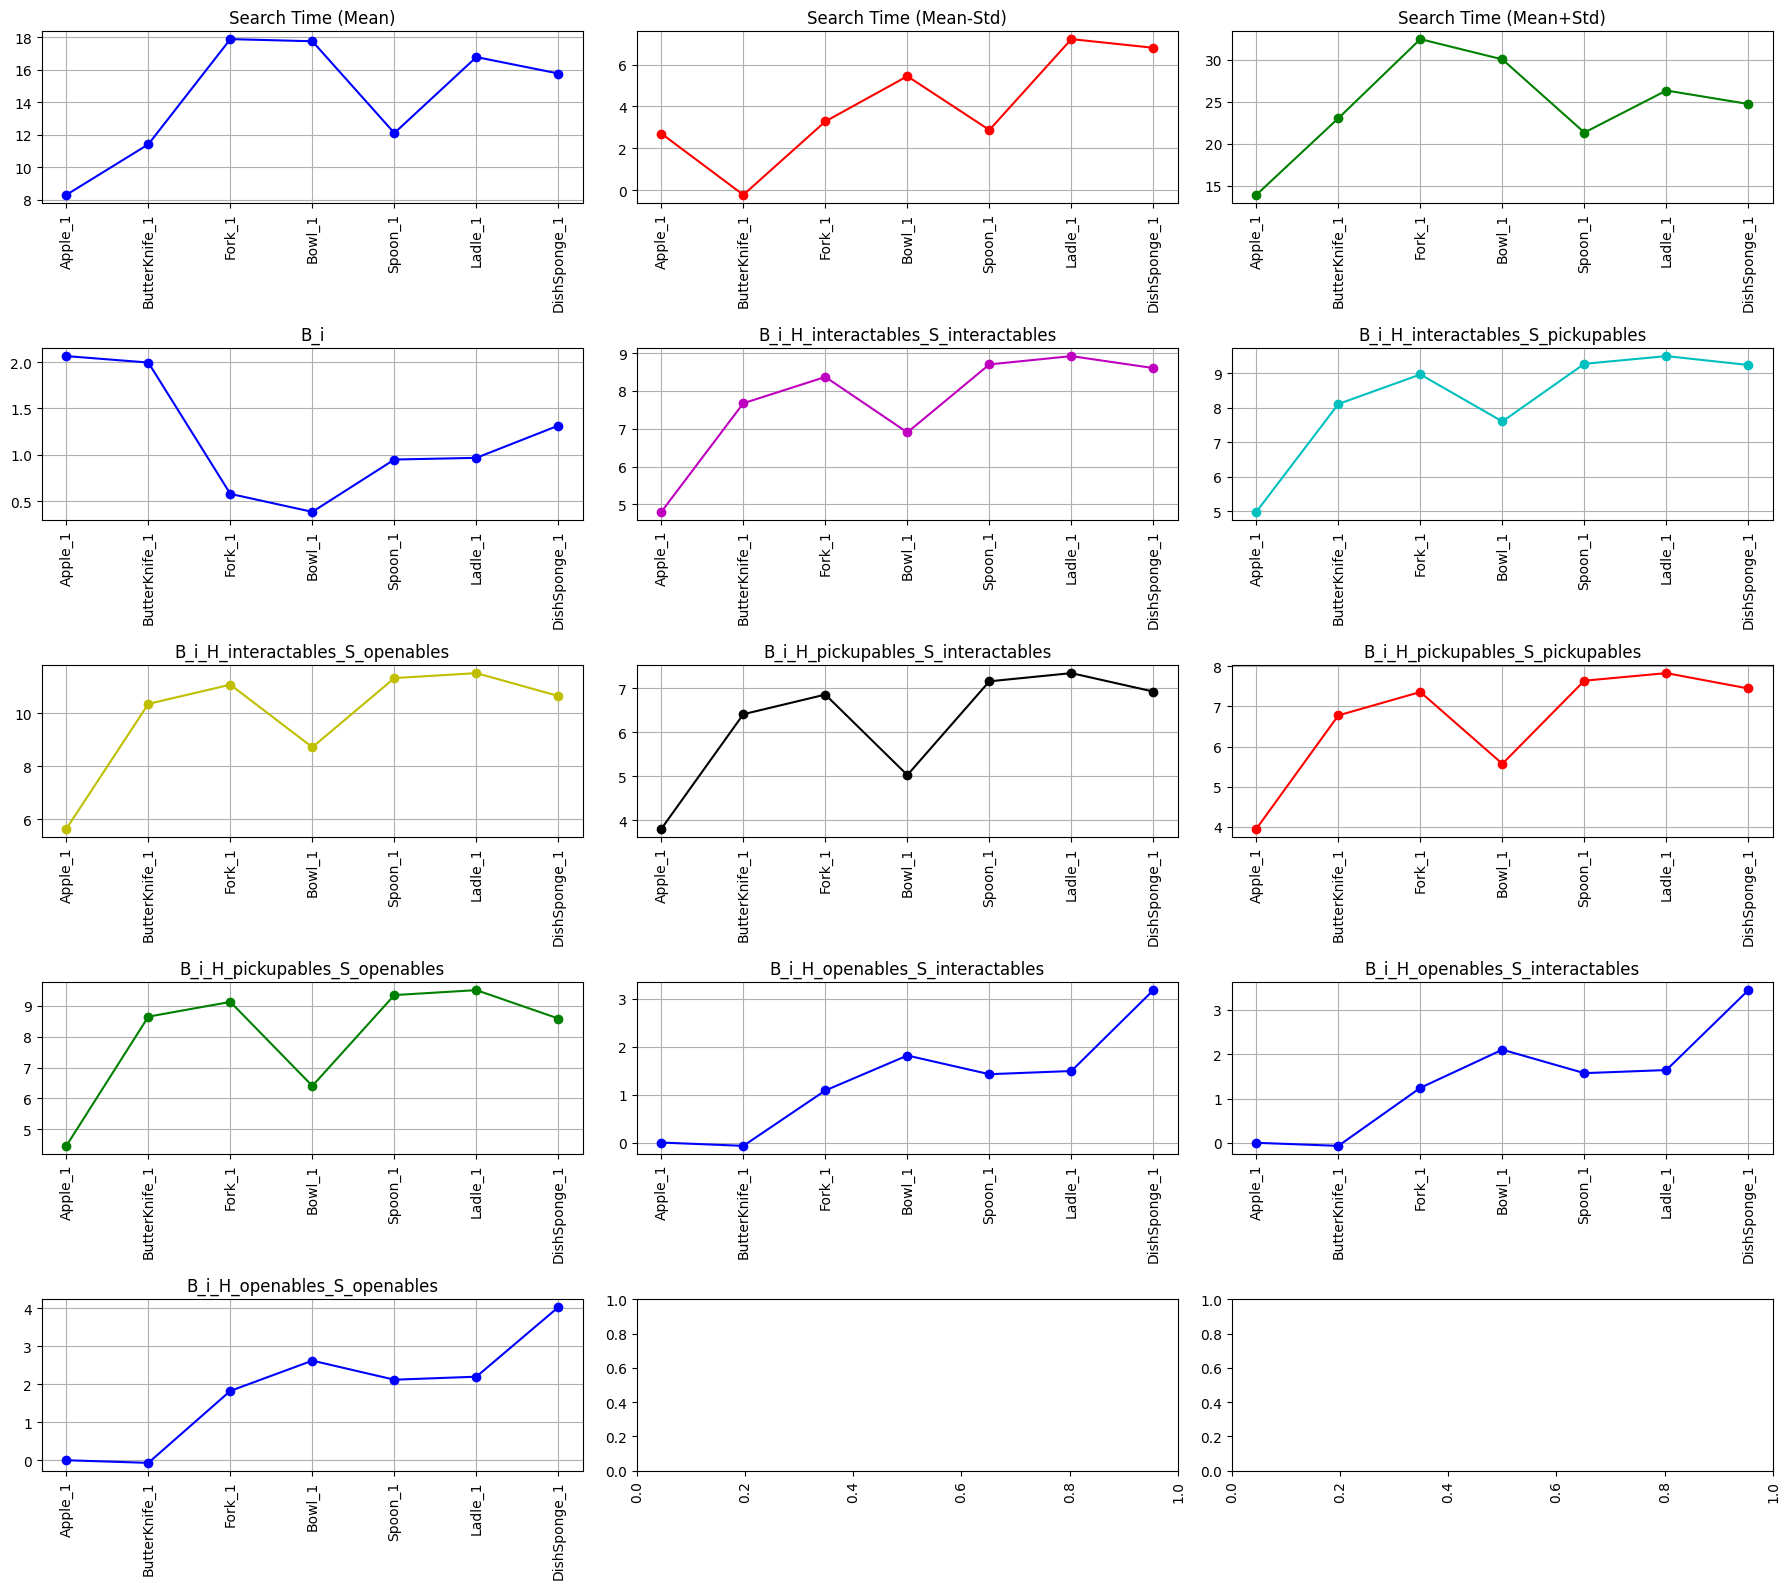

In [149]:

## Create subplots (Search Time + 12 activation metrics)
fig, axes = plt.subplots(5, 3, figsize=(18, 16))  # 4 rows, 3 columns

## Search time plot (first one)
axes[0, 0].plot(x_values[:-1], ST_summary['mean'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title(f'Search Time (Mean)')
axes[0, 0].grid(True)

## Activation metric plots
axes[0, 1].plot(x_values[:-1], ST_summary['mean-std'], marker='o', linestyle='-', color='r')
axes[0, 1].set_title(f'Search Time (Mean-Std)')
axes[0, 1].grid(True)

axes[0, 2].plot(x_values[:-1], ST_summary['mean+std'], marker='o', linestyle='-', color='g')
axes[0, 2].set_title(f'Search Time (Mean+Std)')
axes[0, 2].grid(True)

axes[1, 0].plot(x_values[:-1],[v*-1 for v in by_person_eqn3['B_i'].values()], marker='o', linestyle='-', color='b')
axes[1, 0].set_title(f'B_i')
axes[1, 0].grid(True)

axes[1, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_interactables_S_interactables'].values()], marker='o', linestyle='-', color='m')
axes[1, 1].set_title(f'B_i_H_interactables_S_interactables')
axes[1, 1].grid(True)

axes[1, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_interactables_S_pickupables'].values()], marker='o', linestyle='-', color='c')
axes[1, 2].set_title(f'B_i_H_interactables_S_pickupables')
axes[1, 2].grid(True)

axes[2, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_interactables_S_openables'].values()], marker='o', linestyle='-', color='y')
axes[2, 0].set_title(f'B_i_H_interactables_S_openables')
axes[2, 0].grid(True)

axes[2, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_pickupables_S_interactables'].values()], marker='o', linestyle='-', color='k')
axes[2, 1].set_title(f'B_i_H_pickupables_S_interactables')
axes[2, 1].grid(True)

axes[2, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_pickupables_S_pickupables'].values()], marker='o', linestyle='-', color='r')
axes[2, 2].set_title(f'B_i_H_pickupables_S_pickupables')
axes[2, 2].grid(True)

axes[3, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_pickupables_S_openables'].values()], marker='o', linestyle='-', color='g')
axes[3, 0].set_title(f'B_i_H_pickupables_S_openables')
axes[3, 0].grid(True)

axes[3, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_openables_S_interactables'].values()], marker='o', linestyle='-', color='b')
axes[3, 1].set_title(f'B_i_H_openables_S_interactables')
axes[3, 1].grid(True)

axes[3, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_openables_S_pickupables'].values()], marker='o', linestyle='-', color='b')
axes[3, 2].set_title(f'B_i_H_openables_S_interactables')
axes[3, 2].grid(True)

axes[4, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn3['B_i_H_openables_S_openables'].values()], marker='o', linestyle='-', color='b')
axes[4, 0].set_title(f'B_i_H_openables_S_openables')
axes[4, 0].grid(True)

## Rotate x-axis labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# 
---
# Equation 4.

In [11]:
def calc_activation_4(test_output_data, decay_rate=0.3):
    my_dict = {}
    for k, v in test_output_data.items():
        my_dict[k] = {}
        ## Original
        B_i = 0
        ## 9 different combinations
        B_i_H_interactables_S_interactables = 0
        B_i_H_interactables_S_pickupables = 0
        B_i_H_interactables_S_openables = 0
        B_i_H_pickupables_S_interactables = 0
        B_i_H_pickupables_S_pickupables = 0
        B_i_H_pickupables_S_openables = 0
        B_i_H_openables_S_interactables = 0
        B_i_H_openables_S_pickupables = 0
        B_i_H_openables_S_openables = 0
        
        for obs in v['Observations']:
            duration = obs['End Time'] - obs['Start Time']
            elapsed_time_s = obs['Current Time'] - obs['Start Time']
            elapsed_time_e = obs['Current Time'] - obs['End Time']
            interactables = obs['Num Unique Interactable Objects']
            pickupables = obs['Num Unique Pickupable Objects']
            openables = obs['Num Unique Openable Objects']

            H_interactables = np.log2(interactables) 
            H_pickupables = np.log2(pickupables)
            H_openables = np.log2(openables)
            S_interactables = duration / interactables
            S_pickupables = duration / pickupables
            S_openables = duration / openables
            
            ## 1. Calculate actiation using the original equation
            B_i += elapsed_time_e ** (-decay_rate) # Original equation
            
            ## 2. Calculate actiation using 9 different combinations
            B_i_H_interactables_S_interactables += (elapsed_time_e ** (-decay_rate * H_interactables)) + (S_interactables ** (-decay_rate * H_interactables))
            B_i_H_interactables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_interactables)) + (S_pickupables ** (-decay_rate * H_interactables))
            B_i_H_interactables_S_openables += (elapsed_time_e ** (-decay_rate * H_interactables)) + (S_openables ** (-decay_rate * H_interactables))

            B_i_H_pickupables_S_interactables += (elapsed_time_e ** (-decay_rate * H_pickupables)) + (S_interactables ** (-decay_rate * H_pickupables))
            B_i_H_pickupables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_pickupables)) + (S_pickupables ** (-decay_rate * H_pickupables))
            B_i_H_pickupables_S_openables += (elapsed_time_e ** (-decay_rate * H_pickupables)) + (S_openables ** (-decay_rate * H_pickupables))

            B_i_H_openables_S_interactables += (elapsed_time_e ** (-decay_rate * H_openables)) + (S_interactables ** (-decay_rate * H_openables))
            B_i_H_openables_S_pickupables += (elapsed_time_e ** (-decay_rate * H_openables)) + (S_pickupables ** (-decay_rate * H_openables))
            B_i_H_openables_S_openables += (elapsed_time_e ** (-decay_rate * H_openables)) + (S_openables ** (-decay_rate * H_openables))

        
        ## 
        B_i = np.log(B_i)
        B_i_H_interactables_S_interactables = np.log(B_i_H_interactables_S_interactables)
        B_i_H_interactables_S_pickupables = np.log(B_i_H_interactables_S_pickupables)
        B_i_H_interactables_S_openables = np.log(B_i_H_interactables_S_openables)
        B_i_H_pickupables_S_interactables = np.log(max(B_i_H_pickupables_S_interactables, 1e-6))
        B_i_H_pickupables_S_pickupables = np.log(max(B_i_H_pickupables_S_pickupables, 1e-6))
        B_i_H_pickupables_S_openables = np.log(max(B_i_H_pickupables_S_openables, 1e-6))
        B_i_H_openables_S_interactables = np.log(max(B_i_H_openables_S_interactables, 1e-6))
        B_i_H_openables_S_pickupables = np.log(max(B_i_H_openables_S_pickupables, 1e-6))
        B_i_H_openables_S_openables = np.log(max(B_i_H_openables_S_openables, 1e-6))
        
        
        ## Store results
        my_dict[k] = {
            'B_i': B_i,
            'B_i_H_interactables_S_interactables': B_i_H_interactables_S_interactables,
            'B_i_H_interactables_S_pickupables': B_i_H_interactables_S_pickupables,
            'B_i_H_interactables_S_openables': B_i_H_interactables_S_openables,
            'B_i_H_pickupables_S_interactables': B_i_H_pickupables_S_interactables,
            'B_i_H_pickupables_S_pickupables': B_i_H_pickupables_S_pickupables,
            'B_i_H_pickupables_S_openables': B_i_H_pickupables_S_openables,
            'B_i_H_openables_S_interactables': B_i_H_openables_S_interactables,
            'B_i_H_openables_S_pickupables': B_i_H_openables_S_pickupables,
            'B_i_H_openables_S_openables': B_i_H_openables_S_openables,
        }
    return my_dict

In [122]:
folder_path = "/Users/jongchan/Dropbox/EmbodiedAI/ICCM2025/processed"
folders = glob.glob(os.path.join(folder_path, "*"))
user_summary_eqn4 = {}
index = 1
for f in folders:
    directory, folder_name = os.path.split(f)
    filtered_action_logs = glob.glob(os.path.join(f, "*filtered_action_logs.json"))[0]
    with open(filtered_action_logs, "r") as file:
        filtered_action_logs_data = json.load(file)
    
    test_output = glob.glob(os.path.join(f, "*test_output.json"))[0]
    with open(test_output, "r") as file:
        test_output_data = json.load(file)

    ## Calculate the activaion values
    my_dict = calc_activation_4(test_output_data, decay_rate=0.3)
    user_summary_eqn4[folder_name] = my_dict
    y_values = np.array([v[0]['search_time'] for v in filtered_action_logs_data.values()]) # Search Time
    x_values = list(my_dict.keys())

    # Extract all activation values manually
    values_B_i = np.array([v['B_i'] for v in my_dict.values()])
    values_B_i_H_interactables_S_interactables = np.array([v['B_i_H_interactables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_pickupables = np.array([v['B_i_H_interactables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_interactables_S_openables = np.array([v['B_i_H_interactables_S_openables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_interactables = np.array([v['B_i_H_pickupables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_pickupables = np.array([v['B_i_H_pickupables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_pickupables_S_openables = np.array([v['B_i_H_pickupables_S_openables'] for v in my_dict.values()])
    values_B_i_H_openables_S_interactables = np.array([v['B_i_H_openables_S_interactables'] for v in my_dict.values()])
    values_B_i_H_openables_S_pickupables = np.array([v['B_i_H_openables_S_pickupables'] for v in my_dict.values()])
    values_B_i_H_openables_S_openables = np.array([v['B_i_H_openables_S_openables'] for v in my_dict.values()])

    # ## Create subplots (Search Time + 12 activation metrics)
    # fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4 rows, 3 columns

    # ## Search time plot (first one)
    # axes[0, 0].plot(x_values[:-1], y_values, marker='o', linestyle='-', color='b')
    # axes[0, 0].set_title(f'{folder_name} - Search Time')
    # axes[0, 0].grid(True)

    # ## Activation metric plots
    # axes[0, 1].plot(x_values, values_B_i * -1, marker='o', linestyle='-', color='r')
    # axes[0, 1].set_title(f'B_i')
    # axes[0, 1].grid(True)

    # axes[0, 2].plot(x_values, values_B_i_H_interactables_S_interactables * -1, marker='o', linestyle='-', color='g')
    # axes[0, 2].set_title(f'B_i_H_interactables_S_interactables')
    # axes[0, 2].grid(True)

    # axes[1, 0].plot(x_values, values_B_i_H_interactables_S_pickupables * -1, marker='o', linestyle='-', color='b')
    # axes[1, 0].set_title(f'B_i_H_interactables_S_pickupables')
    # axes[1, 0].grid(True)

    # axes[1, 1].plot(x_values, values_B_i_H_interactables_S_openables * -1, marker='o', linestyle='-', color='m')
    # axes[1, 1].set_title(f'B_i_H_interactables_S_openables')
    # axes[1, 1].grid(True)

    # axes[1, 2].plot(x_values, values_B_i_H_pickupables_S_interactables * -1, marker='o', linestyle='-', color='c')
    # axes[1, 2].set_title(f'B_i_H_pickupables_S_interactables')
    # axes[1, 2].grid(True)

    # axes[2, 0].plot(x_values, values_B_i_H_pickupables_S_pickupables * -1, marker='o', linestyle='-', color='y')
    # axes[2, 0].set_title(f'B_i_H_pickupables_S_pickupables')
    # axes[2, 0].grid(True)

    # axes[2, 1].plot(x_values, values_B_i_H_pickupables_S_openables * -1, marker='o', linestyle='-', color='k')
    # axes[2, 1].set_title(f'B_i_H_pickupables_S_openables')
    # axes[2, 1].grid(True)

    # axes[2, 2].plot(x_values, values_B_i_H_openables_S_interactables * -1, marker='o', linestyle='-', color='r')
    # axes[2, 2].set_title(f'B_i_H_openables_S_interactables')
    # axes[2, 2].grid(True)

    # axes[3, 0].plot(x_values, values_B_i_H_openables_S_pickupables * -1, marker='o', linestyle='-', color='g')
    # axes[3, 0].set_title(f'B_i_H_openables_S_pickupables')
    # axes[3, 0].grid(True)

    # axes[3, 1].plot(x_values, values_B_i_H_openables_S_openables * -1, marker='o', linestyle='-', color='b')
    # axes[3, 1].set_title(f'B_i_H_openables_S_openables')
    # axes[3, 1].grid(True)

    # ## Rotate x-axis labels
    # for ax in axes.flatten():
    #     ax.tick_params(axis='x', rotation=90)

    # plt.tight_layout()
    # plt.show()

    # print("\n", "="*120, "\n")
    index +=1 

In [154]:
by_person_eqn4 = {}
for key in my_dict['Apple_1'].keys():
    by_person_eqn4[key] = {}
    for obj in x_values[:-1]:
        lst = []
        for user, summary in user_summary_eqn4.items():
            lst.append(summary[obj][key])
        by_person_eqn4[key][obj] = np.mean(lst)

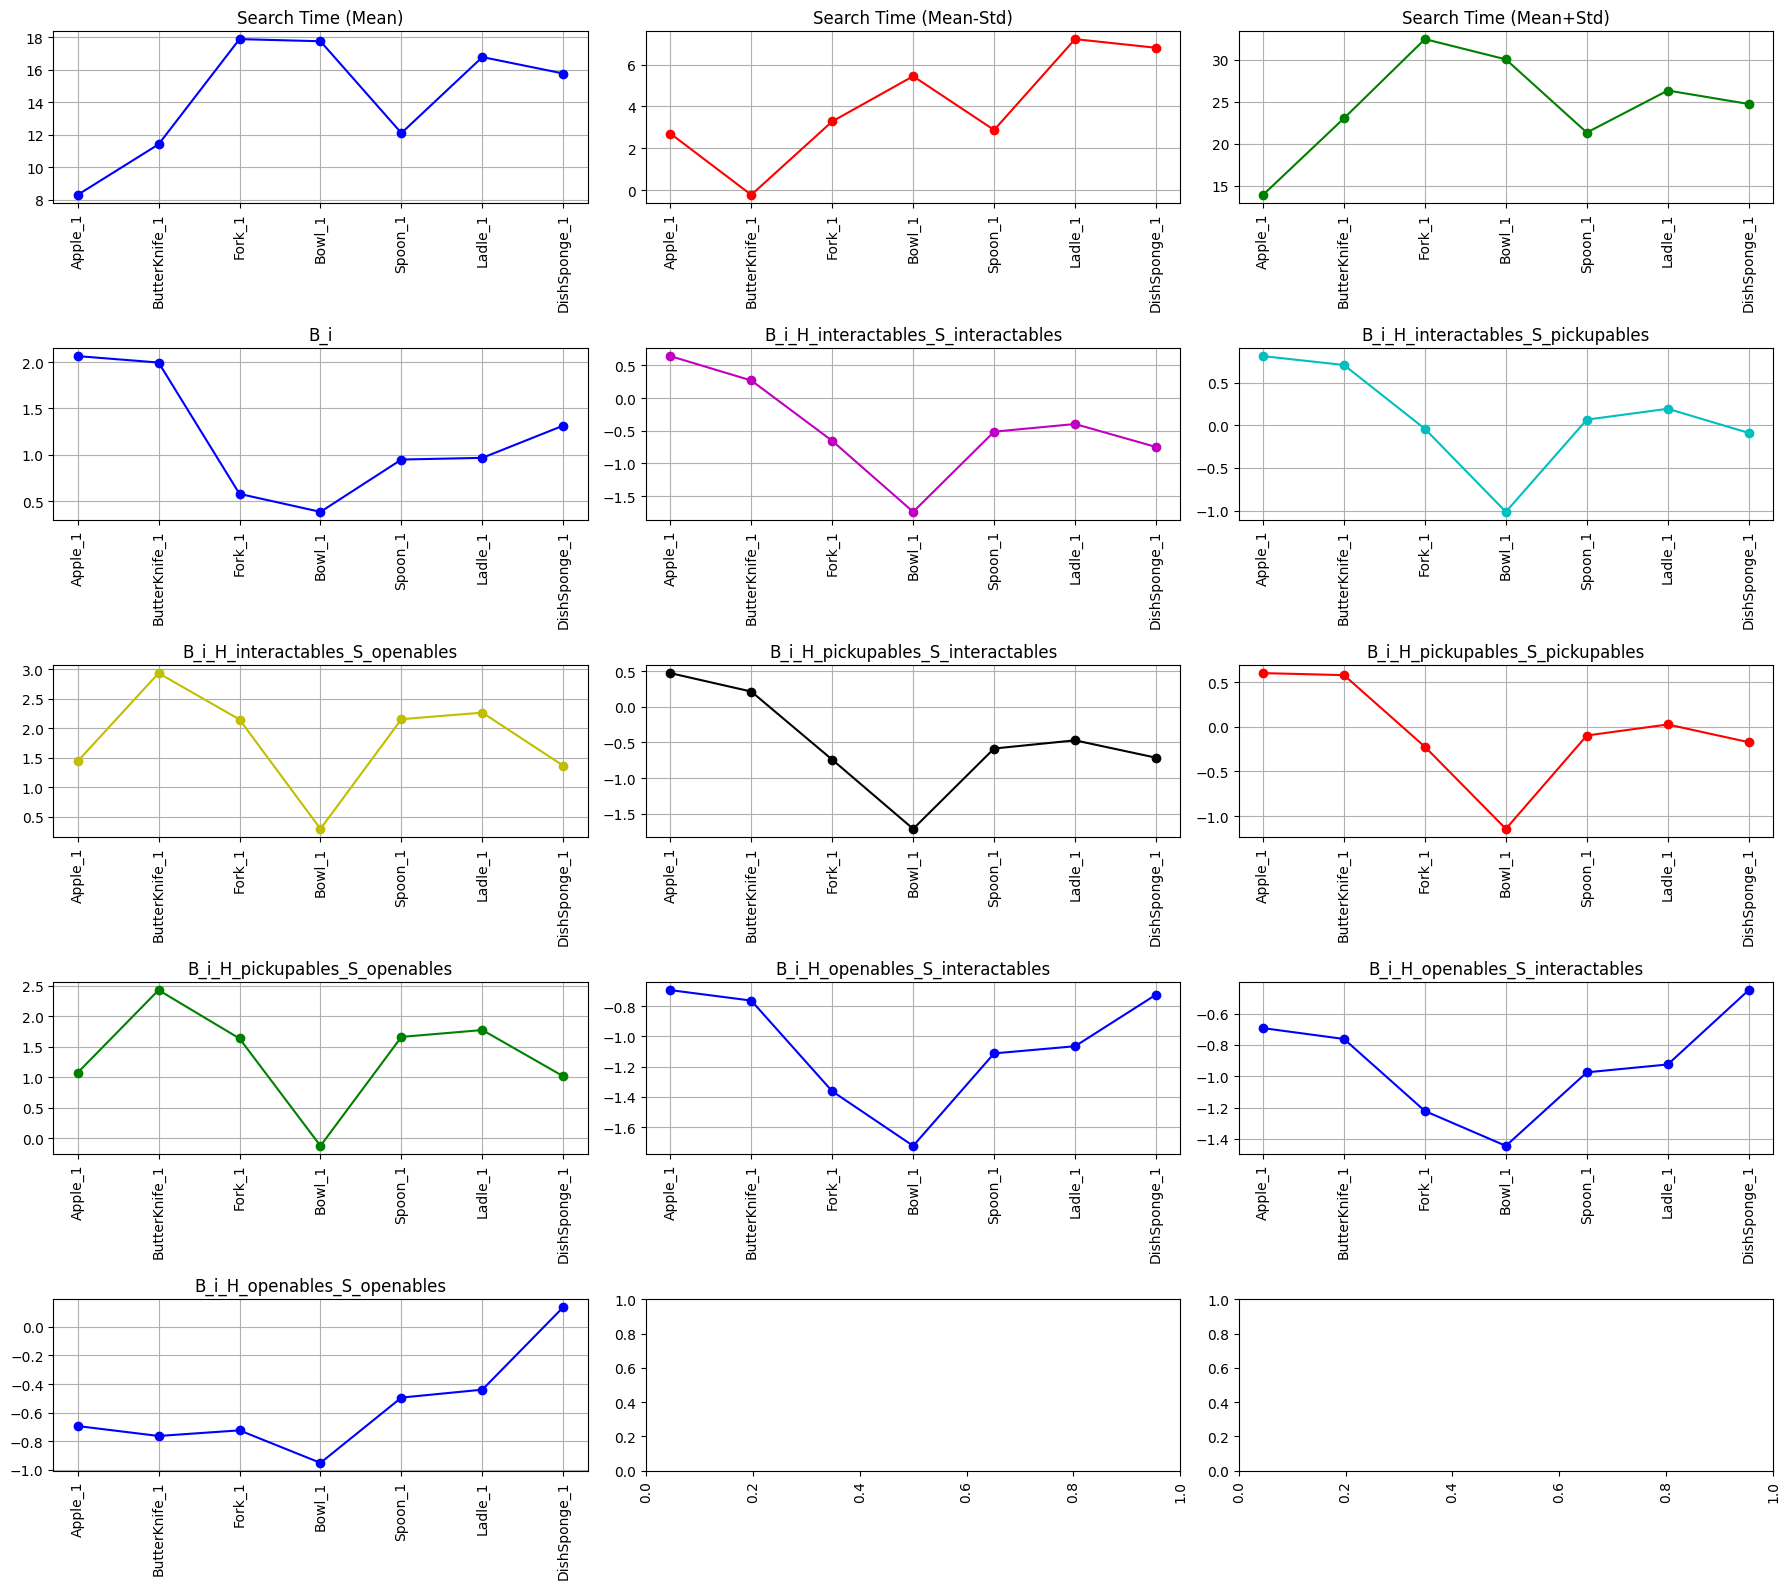

In [150]:
## Create subplots (Search Time + 12 activation metrics)
fig, axes = plt.subplots(5, 3, figsize=(18, 16))  # 4 rows, 3 columns

## Search time plot (first one)
axes[0, 0].plot(x_values[:-1], ST_summary['mean'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title(f'Search Time (Mean)')
axes[0, 0].grid(True)

## Activation metric plots
axes[0, 1].plot(x_values[:-1], ST_summary['mean-std'], marker='o', linestyle='-', color='r')
axes[0, 1].set_title(f'Search Time (Mean-Std)')
axes[0, 1].grid(True)

axes[0, 2].plot(x_values[:-1], ST_summary['mean+std'], marker='o', linestyle='-', color='g')
axes[0, 2].set_title(f'Search Time (Mean+Std)')
axes[0, 2].grid(True)

axes[1, 0].plot(x_values[:-1],[v*-1 for v in by_person_eqn4['B_i'].values()], marker='o', linestyle='-', color='b')
axes[1, 0].set_title(f'B_i')
axes[1, 0].grid(True)

axes[1, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_interactables_S_interactables'].values()], marker='o', linestyle='-', color='m')
axes[1, 1].set_title(f'B_i_H_interactables_S_interactables')
axes[1, 1].grid(True)

axes[1, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_interactables_S_pickupables'].values()], marker='o', linestyle='-', color='c')
axes[1, 2].set_title(f'B_i_H_interactables_S_pickupables')
axes[1, 2].grid(True)

axes[2, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_interactables_S_openables'].values()], marker='o', linestyle='-', color='y')
axes[2, 0].set_title(f'B_i_H_interactables_S_openables')
axes[2, 0].grid(True)

axes[2, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_pickupables_S_interactables'].values()], marker='o', linestyle='-', color='k')
axes[2, 1].set_title(f'B_i_H_pickupables_S_interactables')
axes[2, 1].grid(True)

axes[2, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_pickupables_S_pickupables'].values()], marker='o', linestyle='-', color='r')
axes[2, 2].set_title(f'B_i_H_pickupables_S_pickupables')
axes[2, 2].grid(True)

axes[3, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_pickupables_S_openables'].values()], marker='o', linestyle='-', color='g')
axes[3, 0].set_title(f'B_i_H_pickupables_S_openables')
axes[3, 0].grid(True)

axes[3, 1].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_openables_S_interactables'].values()], marker='o', linestyle='-', color='b')
axes[3, 1].set_title(f'B_i_H_openables_S_interactables')
axes[3, 1].grid(True)

axes[3, 2].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_openables_S_pickupables'].values()], marker='o', linestyle='-', color='b')
axes[3, 2].set_title(f'B_i_H_openables_S_interactables')
axes[3, 2].grid(True)

axes[4, 0].plot(x_values[:-1], [v*-1 for v in by_person_eqn4['B_i_H_openables_S_openables'].values()], marker='o', linestyle='-', color='b')
axes[4, 0].set_title(f'B_i_H_openables_S_openables')
axes[4, 0].grid(True)

## Rotate x-axis labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()